# 1) Assembling the Dataset 
In this section, we will be doing the following: 

1. Import necessary libraries and modules
2. Load dataset 

## 1. Import necessary libraries and modules

In [1]:
!pip install xgboost
!pip install squarify
!python -m pip uninstall -y imbalanced-learn
!pip install scikit-learn==0.24.2
!pip install imblearn

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer    
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split
import plotly.express as px
import warnings
import imblearn
from imblearn.over_sampling import SMOTE

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam
# outdated: from keras.preprocessing import sequence 
from keras.utils.data_utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

import squarify

## 2. Load Dataset

### Create a dataframe

In [123]:
df = pd.read_csv('mbti_1.csv')
#df = pd.read_csv('mbti_1.csv', index_col=False)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [124]:
df2 = pd.read_csv('trumptweets.csv', encoding='ISO-8859-1')
df2.head()

,Tweets
0,Thank you to all of the television viewers tha...
1,Can you imagine if I had the small crowds that...
2,NATO commander agrees members should pay up vi...
3,"Wow, NATO's top commander just announced that ..."
4,"The ""Rust Belt"" was created by politicians lik..."


In [122]:
df2['Tweets']

0        Thank you to all of the television viewers tha...
1        Can you imagine if I had the small crowds that...
2        NATO commander agrees members should pay up vi...
3        Wow, NATO's top commander just announced that ...
4        The "Rust Belt" was created by politicians lik...
                               ...                        
29879    "My persona will never be that of a wallflower...
29880    New Blog Post: Celebrity Apprentice Finale and...
29881    Donald Trump reads Top Ten Financial Tips on L...
29882    Donald Trump will be appearing on The View tom...
29883    Be sure to tune in and watch Donald Trump on L...
Name: Tweets, Length: 29884, dtype: object

# 2) Choosing a measure of success

## Accuracy 

The measure of success I have chosen to use is accuracy. Accuracy is well-suited to the specific nature of this project for several reasons.

Firstly, the project involves predicting MBTI personality types. In this context, the consequences of a false positive, where the model predicts the wrong personality type, are not severe. There are no ethical implications or critical outcomes associated with such errors. False positives may result in additional work but does not carry significant adverse effects.

Secondly, accuracy is an intuitive and interpretable metric for both technical and non-technical stakeholders. It provides a straightforward assessment of the model's performance by quantifying the proportion of correct predictions.

Thirdly, the choice of accuracy is bolstered by the use of categorical cross-entropy as the loss function. This loss function is specifically tailored for multiclass classification tasks, aligning with our project's objective of predicting MBTI personality types.

## Loss and Accuracy graphs
The accuracy and loss graphs serve as valuable visual indicators of model performance throughout the training process. By tracking these metrics on both the training and validation datasets, we gain insights into whether the model is underfitting, overfitting, or achieving an optimal fit. A good-fit model demonstrates consistent accuracy improvements and loss reductions on both datasets, while overfitting is signaled by a significant performance gap between training and validation data. Conversely, underfitting indicates that the model has not learned the underlying patterns in the data. These graphs, therefore, provide essential guidance for model refinement, ensuring that it converges towards an effective and balanced state.

# 3) Deciding on an evaluation protocol

## Iterated K-Fold Cross-Validation

Considering my relatively small dataset containing 8675 data and the emphasis on achieving high model accuracy, the iterated k-Fold Cross-Validation approach would be the best evaluation protocol. 

Given the limited dataset size, this approach minimizes the risk of overfitting, as it repeatedly assesses the model on diverse data subsets. Iterated k-Fold Cross-Validation combines the advantages of k-Fold Cross-Validation with the robustness gained from repeated iterations. This protocol partitions the dataset into k subsets, or "folds," and iteratively uses each fold as a validation set while training the model on the remaining data. This process is repeated multiple times, shuffling the data differently in each iteration. This reduces the impact of variability introduced by the random splitting of data leading to a more reliable assessment of your model's ability to generalize to new, unseen data. 

## 3. Data Cleaning
Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. Cleaning our dataset ensures data accuracy, reliability and quality for effective analysis and modelling. 

* Case Standardisation
* Remove Stopwords
* Remove URLs and punctuations
* Lemmatization

In [6]:
def clean_data(x):
    data_length=[]
    wnl=WordNetLemmatizer()
    cleaned_text=[]
    stop_words = set(stopwords.words('english')) # Load stop words
    mbti_types = [ "ISTJ", "ESFJ", "ISTJ","ISFP",
                  "ESTJ", "ESFP", "ENFP","ISTP",
                  "INFP", "ESTP", "INTP", "ENTP", 
                  "ENFJ", "INTJ", "ENTJ", "INFJ" ]
    mbti_types = [t.lower() for t in mbti_types]
    
    for sent in df.posts:
        
        # Case Standardisation
        sent=sent.lower()
        
        # Remove URLs
        # source: Gabriel Giraldo-Wingler https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
        sent=re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*',' ',sent)
        
        # Remove punctuations
        sent=re.sub('[^0-9a-z]',' ',sent)
        
        # Remove stop words
        sent = " ".join([word for word in sent.split() if word not in stop_words]) 
        
        for t in mbti_types:
            sent = re.sub(t, '', sent)
            
        # Lemmatize
        sent = wnl.lemmatize(sent) 
        
        data_length.append(len(sent.split())) #Split data, measure length of new filtered data
        
        cleaned_text.append(sent)
        
    return cleaned_text,data_length

In [7]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [125]:
df_clean = df
df_clean.posts,df_clean_length=clean_data(df)
df_clean

,type,posts
0,INFJ,jpg moments sportscenter top ten plays prank...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear enjoyed conversation day esoteric gabbin...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else html post...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


In [121]:
df_clean2 = df2
df_clean2.posts, df_clean2_length = clean_data(df2)
df_clean2

/var/folders/tl/pjvv24r97gb_70lb57b6jp680000gn/T/ipykernel_23104/2030002427.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_clean2.posts, df_clean2_length = clean_data(df2)


,Tweets
0,Thank you to all of the television viewers tha...
1,Can you imagine if I had the small crowds that...
2,NATO commander agrees members should pay up vi...
3,"Wow, NATO's top commander just announced that ..."
4,"The ""Rust Belt"" was created by politicians lik..."
...,...
29879,"""My persona will never be that of a wallflower..."
29880,New Blog Post: Celebrity Apprentice Finale and...
29881,Donald Trump reads Top Ten Financial Tips on L...
29882,Donald Trump will be appearing on The View tom...


# Preprocessing Data

### 1. Split data into train and test sets
The dataset is divided into training and testing sets in a 80:20 ratio. The training set is used for training the model and the testing set is used as a collection of data points that will help to assess the performance of the model in generalising new, unseen data

In [126]:
X = df['posts']
y = df['type']

X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(df_clean['posts'],df_clean['type'], 
                                         test_size=0.2,
                                         random_state=0, 
                                         stratify= df.type)  

### 2. Label Encoding

Machine Learning cannot interpret strings on our target values. Thus, we need to convert categorical data into numerical values before they can be fitted into our machine learning models. Each category is assigned a unique integer.

In [127]:
# create an instance of label encoder 
labelencoder= LabelEncoder()
# Fit and transform the labels to numerical format
y_train_gru_enc = labelencoder.fit_transform(y_train_gru)
y_test_gru_enc = labelencoder.transform(y_test_gru)

In [141]:
import joblib
joblib.dump(labelencoder, 'labelencoder.pkl')

['labelencoder.pkl']

### 3. One hot encoding

The model would require categorically encoded labels where each label will be turned into a 10-element vector of zeros except for a single element. This is called one-hot encoding using to_categorical where at the position in the vector that corresponds to the label will be encoded with a one in the (n+1)th position. 

In [128]:
from keras.utils import to_categorical

# One-hot encode the target labels
y_train_gru_onehot = to_categorical(y_train_gru_enc)
y_test_gru_onehot = to_categorical(y_test_gru_enc)

### 4. Tokenization and Padding Sequences
Tokenization is the process of splitting text into individual words or tokens. Padded sequences are used to make all input sequences of the same length by adding padding tokens. Both are essential for processing text data with varying lengths, as most machine learning models require fixed-length input.

In [129]:
from keras.preprocessing.text import Tokenizer
max_words = 2500
max_len = 40

# ensure all sequences in a list have the same length
def tokenize_pad_sequences(text):
    # initialise text tokenizer
    tokenizer = Tokenizer(num_words=max_words, filters="")
    
    # generate word indexes
    tokenizer.fit_on_texts(text)
    
    # transforms text to a sequence of integers and apply padding 
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len) #post padding  
    
    # return sequences 
    return X, tokenizer

In [130]:
from keras.preprocessing.text import Tokenizer
max_words = 2500
max_len = 40

X_train_gru_pad, tokenizer = tokenize_pad_sequences(X_train_gru)
X_test_gru_pad = tokenizer.texts_to_sequences(X_test_gru)
X_test_gru_pad = pad_sequences(X_test_gru_pad, padding='post', maxlen=max_len)

### 5. Word Embedding 

A word embedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. 

We are using GloVe for this project.

In [131]:
import os
DATA_DIR = "data"
GLOVE_PATH = os.path.join(DATA_DIR, "glove.6B.50d.txt")


# load GloVe embedding 
embeddings_index = dict()
with open(GLOVE_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefficients

In [132]:
max_words = 2500 
EMBEDDING_VECTOR_LENGTH = 50 
# create an embedding matrix 
embedding_matrix = np.zeros((max_words, EMBEDDING_VECTOR_LENGTH))
for word, index in tokenizer.word_index.items():
    if index < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### 6. Handling Imbalanced Data

To handle the imbalanced data, we will be using SMOTE to balance the class distribution.

In [133]:
# Instantiate the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=0)

# Apply SMOTE to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_gru_pad, y_train_gru_enc)

In [134]:
print('X_train_resampled', X_train_resampled.shape)
print('y_train_resampled', y_train_resampled.shape)

X_train_resampled (23456, 40)
y_train_resampled (23456,)


### Helper functions to plot accuracy and loss graphs 

In [135]:
def plot_loss(loss, val_loss):
    plt.clf() #clear any existing figure
    epochs = range(1, len(loss)+1) #get number of epochs
    # Calculate the average loss over epochs
    avg_loss = [np.mean(loss[:i]) for i in range(1, len(loss) + 1)]
    avg_val_loss = [np.mean(val_loss[:i]) for i in range(1, len(val_loss) + 1)]
    # assign values for each axis
    plt.plot(epochs, avg_loss, 'bo', label="Loss")
    plt.plot(epochs, avg_val_loss, 'b', label="Average Validation Loss")
    #set a title of graph and labels of each axis
    plt.title("Average Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()    

In [136]:
def plot_acc(acc, val_acc):
    plt.clf()
    epochs = range(1, len(acc)+1) #gets a number of epochs
    # Calculate the average loss over epochs
    avg_acc = [np.mean(acc[:i]) for i in range(1, len(acc) + 1)]
    avg_val_acc = [np.mean(val_acc[:i]) for i in range(1, len(val_acc) + 1)]
    
    # assign values for each axis
    plt.plot(epochs, avg_acc, 'bo', label="Accuracy")
    plt.plot(epochs, avg_val_acc, 'b', label="Average Validation Accuracy")
    #set a title of graph and labels of each axis
    plt.title("Average Training Accuracy & Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.legend()
    plt.show()     

# GRU: Developing a model that does better than the baseline

## Baseline

A baseline model serves as a starting point for comparison in machine learning tasks, representing a simple or default approach to establish a performance benchmark.

As there are a total of 16 distinct labels in our dataset, the percentage of accuracy is 1/16 = 0.0625 or 6.25%. 

We will use this value as our baseline to aim to develop a model that produces an accuracy of greater than 0.0625 in order to achieve statistical power. 

#### Building the model
- initialise model 
- add layers to model
- compile model 

#### Train model with Iterated K-fold Validation

In [27]:
K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 1

all_val_acc_1 = []
all_val_loss_1 = []

all_acc_1 = []
all_loss_1 = []
all_acc_history_1 = []
all_loss_history_1 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    underfit_gru_model = Sequential()

    # Defining model: add layers 
    underfit_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding
    underfit_gru_model.add(GRU(64, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH))) #GRU layer 
    underfit_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    underfit_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(underfit_gru_model.summary())

    
    # train model
    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model (in silent mode, verbose=0)
            underfit_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_1 = underfit_gru_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = underfit_gru_model.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_1.append(val_acc)
            all_val_loss_1.append(val_loss)

            acc = results_1.history['accuracy']
            all_acc_1.append(acc)
            acc_history = results_1.history['val_accuracy']
            all_acc_history_1.append(acc_history)

            loss = results_1.history['loss']
            all_loss_1.append(loss)
            loss_history = results_1.history['val_loss']
            all_loss_history_1.append(loss_history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 50)            125000    
                                                                 
 gru_1 (GRU)                 (None, 64)                22272     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
Total params: 148,312
Trainable params: 148,312
Non-trainable params: 0
_________________________________________________________________
None
processing fold 0
147/147 - 11s - loss: 2.7873 - accuracy: 0.0647 - val_loss: 2.7760 - val_accuracy: 0.0784 - 11s/epoch - 76ms/step
processing fold 1
147/147 - 10s - loss: 2.7574 - accuracy: 0.0874 - val_loss: 2.7504 - val_accuracy: 0.0893 - 10s/epoch - 68ms/step
processing fold 2
147/147 - 9s - loss: 2.68

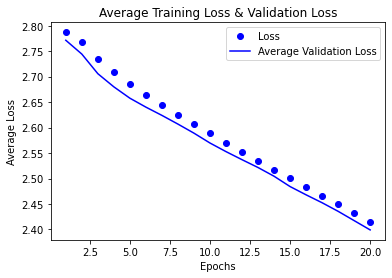

In [22]:
plot_loss(all_loss_1, all_loss_history_1)

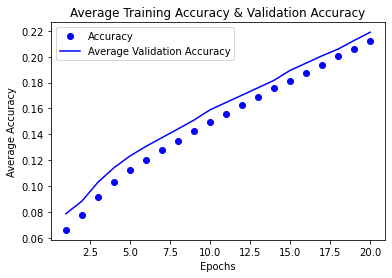

In [23]:
plot_acc(all_acc_1, all_acc_history_1)

In [24]:
print("Average Loss:", np.mean(all_val_loss_1))
print("Average Accuracy:", np.mean(all_val_acc_1))

Average Loss: 2.399054217338562
Average Accuracy: 0.21886860728263854


From the graphs plotted, we can observe that there is slight underfitting as the training accuracy grpah is below the average validation accuracy graph.

Despite being an underfitting model, our model has an average accuracy that is higher (21.9%) than the baseline (6.25%).

Now we will develop a model that overfits. 

# GRU: Developing a model that overfits/scaled up
After developing a model that is able to do better than the baseline, we need to develop a model that overfits/scaled up. As the aim of this project is to create a model that stands on the line between overfitting and underfitting, we now need to cross the line to develop a model that overfits. 

We will be developing an overfitting model by changing:
1. <b>number of GRU and dense layers</b> 
2. <b>batch_size</b>
3. <b>number of epochs</b>

### 1. increasing the number of GRU and dense layers
Using the 'relu' (Rectified Linear Unit) activation function for intermediate dense layers and 'softmax' activation for the output layer is a common practice in deep learning for classification tasks. Here's why this combination is used:

Intermediate Layers ('relu' activation): The 'relu' activation function is commonly used in intermediate layers because it introduces non-linearity to the network. This non-linearity allows the model to learn complex patterns in the data. 'relu' is computationally efficient and helps mitigate the vanishing gradient problem during training. It's effective for feature extraction and can model complex relationships in the data.

Output Layer ('softmax' activation): The 'softmax' activation is typically used in the output layer for multi-class classification problems. It transforms the raw output scores of the model into probability distributions over the classes. In other words, it converts the model's final layer outputs into class probabilities, where each class gets a probability score. This is useful because it allows you to interpret the model's output as class probabilities and choose the class with the highest probability as the predicted class.

### 2. batch_size = 128 

#### Build and Train model with Iterated K-fold Validation 

In [30]:
max_len = 40
EMBEDDING_VECTOR_LENGTH = 50
K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_2 = []
all_val_loss_2 = []

all_acc_2 = []
all_loss_2 = []
all_acc_history_2 = []
all_loss_history_2 = []

N_iterations=4
N_folds=5
    
with tf.device("/gpu:0"):
    # Initialising the model 
    overfit_gru_model = Sequential()

    # Defining model: add layers 
    overfit_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding
    overfit_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    overfit_gru_model.add(GRU(64)) 
    overfit_gru_model.add(Dense(64, activation='relu')) # Additional dense layer
    overfit_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    overfit_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(overfit_gru_model.summary())
    
    # train model 
    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model (in silent mode, verbose=0)
            overfit_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_2 = overfit_gru_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=0, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = overfit_gru_model.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_2.append(val_acc)
            all_val_loss_2.append(val_loss)

            acc = results_2.history['accuracy']
            all_acc_2.append(acc)
            acc_history = results_2.history['val_accuracy']
            all_acc_history_2.append(acc_history)

            loss = results_2.history['loss']
            all_loss_2.append(loss)
            loss_history = results_2.history['val_loss']
            all_loss_history_2.append(loss_history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 50)            125000    
                                                                 
 gru_6 (GRU)                 (None, 40, 128)           69120     
                                                                 
 gru_7 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
Total params: 236,568
Trainable params: 236,568
Non-trainable params: 0
_________________________________________________________________
None
processing fold 0
processing fold 1
process

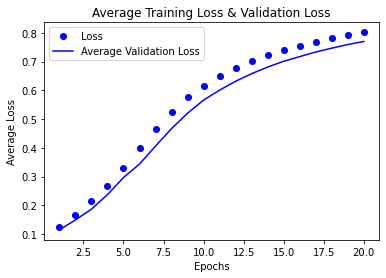

In [34]:
plot_loss(all_acc_2, all_acc_history_2)

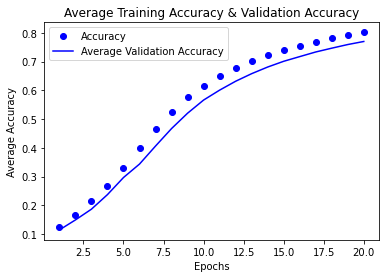

In [33]:
plot_acc(all_acc_2, all_acc_history_2)

In [32]:
print("Average Loss:", np.mean(all_val_loss_2))
print("Average Accuracy:", np.mean(all_val_acc_2))

Average Loss: 0.7786767250858248
Average Accuracy: 0.7475964777171612


From the plotted graphs, we can see the training accuracy being higher than the average validation accuracy which suggests that the model is overfitting. The average accuracy of our overfitting model is 74.8% which is more than 3 times higher than our underfitting model with an accuracy of 21.9%.

Now we will start regularising the hyperparamters of our overfitting model to prevent overfitting and improve the performance of the model.

### 3. Number of epochs = 5
The number of epochs we have used in training the neural network is very small as it takes extremely long to run the training if the number of epochs exceeds 5. In reality, the epoch number should be much higher to ensure better training. 

# LSTM: Regularizing your model and tuning your hyperparameters
After creating a model that overfits, we need to modify the model to increase the peformance of the model. We can do this by regularizing the model and iteratively fine tune our hyperparameters until we determine the optimal hyperparameter settings that results in the best performing machine learning model.

There are many ways to regularize the model. For our project, we will be tuning:
1. Dropout rates
2. L1/L2 regularizers

Batch Normalization will also be applied to accelerate training of the model.

We will be testing different settings for the hyperparameters and compare the performances between them to determine the optimal setting for dropout and L1/L2 regularizers.

Finally, we will add the hyperparameters with the optimal values we found earlier to our overfitting LSTM model to develop the final LSTM model.

### 1. Dropout

By adding dropout layers, you introduce some randomness during training, which can help prevent the model from relying too heavily on any single feature and reduce overfitting. 

#### Build model with Dropout = 0.1

In [37]:
### DROP OUT = 0.1 ###

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_3 = []
all_val_loss_3 = []

all_acc_3 = []
all_loss_3 = []
all_acc_history_3 = []
all_loss_history_3 = []

N_iterations=4
N_folds=5

from tensorflow.keras.layers import Dropout


with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_1 = Sequential()

    # Defining model: add layers 
    gru_model_1.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding


    gru_model_1.add(Dropout(0.1)) #dropout layer with 0.1 rate
    gru_model_1.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True))
    gru_model_1.add(GRU(64))
    gru_model_1.add(Dense(64, activation='relu'))
    gru_model_1.add(Dropout(0.1))
    gru_model_1.add(Dense(16, activation='softmax'))

    # Compile model
    gru_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_1.summary())

    import numpy as np 
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import mean_absolute_error


    # Train the model       
    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_3 = gru_model_1.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_1.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_3.append(val_acc)
            all_val_loss_3.append(val_loss)

            acc = results_3.history['accuracy']
            all_acc_3.append(acc)
            acc_history = results_3.history['val_accuracy']
            all_acc_history_3.append(acc_history)

            loss = results_3.history['loss']
            all_loss_3.append(loss)
            loss_history = results_3.history['val_loss']
            all_loss_history_3.append(loss_history)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 40, 50)            125000    
                                                                 
 dropout_4 (Dropout)         (None, 40, 50)            0         
                                                                 
 gru_8 (GRU)                 (None, 40, 128)           69120     
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

Epoch 5/5
147/147 - 16s - loss: 0.7777 - accuracy: 0.7339 - val_loss: 0.7005 - val_accuracy: 0.7679 - 16s/epoch - 109ms/step
processing fold 1
Epoch 1/5
147/147 - 20s - loss: 0.8831 - accuracy: 0.7041 - val_loss: 0.3824 - val_accuracy: 0.9043 - 20s/epoch - 136ms/step
Epoch 2/5
147/147 - 16s - loss: 0.8132 - accuracy: 0.7257 - val_loss: 0.4157 - val_accuracy: 0.8891 - 16s/epoch - 110ms/step
Epoch 3/5
147/147 - 16s - loss: 0.7873 - accuracy: 0.7363 - val_loss: 0.4545 - val_accuracy: 0.8691 - 16s/epoch - 110ms/step
Epoch 4/5
147/147 - 17s - loss: 0.7328 - accuracy: 0.7552 - val_loss: 0.4816 - val_accuracy: 0.8525 - 17s/epoch - 113ms/step
Epoch 5/5
147/147 - 16s - loss: 0.6985 - accuracy: 0.7665 - val_loss: 0.5193 - val_accuracy: 0.8369 - 16s/epoch - 107ms/step
processing fold 2
Epoch 1/5
147/147 - 20s - loss: 0.7973 - accuracy: 0.7337 - val_loss: 0.2752 - val_accuracy: 0.9390 - 20s/epoch - 134ms/step
Epoch 2/5
147/147 - 16s - loss: 0.7429 - accuracy: 0.7505 - val_loss: 0.3101 - val_accura

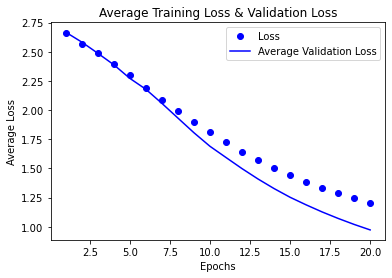

In [38]:
plot_loss(all_loss_3, all_loss_history_3)

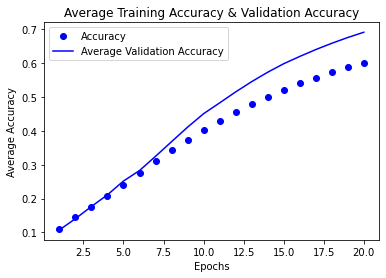

In [39]:
plot_acc(all_acc_3, all_acc_history_3)

In [40]:
print("Average Loss:", np.mean(all_val_loss_3))
print("Average Accuracy:", np.mean(all_val_acc_3))

Average Loss: 1.0217864368110896
Average Accuracy: 0.6685225442051888


From the graphs plotted above, we can see that the training accuracy is now below the averge validation accuracy which suggest undefitting.

Upon adding dropouts of 0.1, the overfitting model became underfitting. As the aim of the project is to create a model that stands on the line between overfitting and underfitting, we need to reduce the underfitting by using a dropout rate that is smaller than 0.1.

#### GRU Model with Dropout=0.07

In [44]:
### DROP OUT = 0.07 ###
from tensorflow.keras.layers import Dropout
K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_4 = []
all_val_loss_4 = []

all_acc_4 = []
all_loss_4 = []
all_acc_history_4 = []
all_loss_history_4 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_2 = Sequential()

    # Defining model: add layers 
    gru_model_2.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    gru_model_2.add(Dropout(0.07)) #dropout layer with 0.05 rate
    gru_model_2.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True))
    gru_model_2.add(GRU(64))
    gru_model_2.add(Dense(64, activation='relu'))
    gru_model_2.add(Dropout(0.07))
    gru_model_2.add(Dense(16, activation='softmax'))

    # Compile model
    gru_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_2.summary())
    
    # Train model
    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_4 = gru_model_2.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_2.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_4.append(val_acc)
            all_val_loss_4.append(val_loss)

            acc = results_4.history['accuracy']
            all_acc_4.append(acc)
            acc_history = results_4.history['val_accuracy']
            all_acc_history_4.append(acc_history)

            loss = results_4.history['loss']
            all_loss_4.append(loss)
            loss_history = results_4.history['val_loss']
            all_loss_history_4.append(loss_history)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 40, 50)            125000    
                                                                 
 dropout_10 (Dropout)        (None, 40, 50)            0         
                                                                 
 gru_14 (GRU)                (None, 40, 128)           69120     
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 16)              

Epoch 5/5
147/147 - 16s - loss: 0.5865 - accuracy: 0.8005 - val_loss: 0.5852 - val_accuracy: 0.8022 - 16s/epoch - 108ms/step
processing fold 1
Epoch 1/5
147/147 - 20s - loss: 0.6886 - accuracy: 0.7699 - val_loss: 0.2362 - val_accuracy: 0.9501 - 20s/epoch - 136ms/step
Epoch 2/5
147/147 - 16s - loss: 0.6005 - accuracy: 0.7983 - val_loss: 0.2669 - val_accuracy: 0.9299 - 16s/epoch - 108ms/step
Epoch 3/5
147/147 - 16s - loss: 0.5847 - accuracy: 0.8011 - val_loss: 0.3084 - val_accuracy: 0.9184 - 16s/epoch - 107ms/step
Epoch 4/5
147/147 - 16s - loss: 0.5399 - accuracy: 0.8189 - val_loss: 0.3300 - val_accuracy: 0.8992 - 16s/epoch - 107ms/step
Epoch 5/5
147/147 - 16s - loss: 0.5076 - accuracy: 0.8267 - val_loss: 0.3740 - val_accuracy: 0.8860 - 16s/epoch - 109ms/step
processing fold 2
Epoch 1/5
147/147 - 20s - loss: 0.5994 - accuracy: 0.7987 - val_loss: 0.1639 - val_accuracy: 0.9678 - 20s/epoch - 135ms/step
Epoch 2/5
147/147 - 16s - loss: 0.5382 - accuracy: 0.8218 - val_loss: 0.1914 - val_accura

3 sep 6:35pm ran dropout=0.07 gru_model_2 

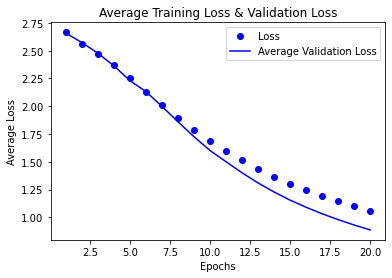

In [45]:
plot_loss(all_loss_4, all_loss_history_4)

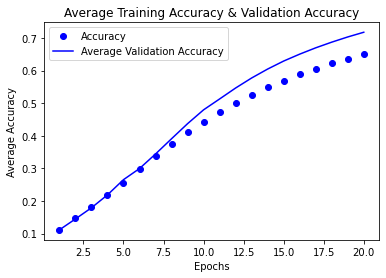

In [46]:
plot_acc(all_acc_4, all_acc_history_4)

In [47]:
print("Average Loss:", np.mean(all_val_loss_4))
print("Average Accuracy:", np.mean(all_val_acc_4))

Average Loss: 0.9383449828252196
Average Accuracy: 0.6955946207046508


The average accuracy for Dropout=0.07 (69.6%) is higher than that of Dropout=0.1(66.9%).

The average loss of the former (93.8%) is greater than the latter (102%).

From the plotted graphs, we can observe that we have achieved a model with a better fit where the training and validation curves are close to one another without overfitting when Dropout rate was lowered to 0.07.

Hence, we can conclude that a smaller dropout values, dropout=0.07, is better than dropout=0.1 as the former is able to generalise better to unseen data.

### 2. L1/L2 Regularizers + Batch Normalization 

To accelerate the training, we will be adding batch normalization layers after each layer of the neural network. Batch Normalization normalizes and adds noise to the activations of the previous layer, which helps prevent overfitting and makes training more robust.

#### Build and train the Model with L1/L2 Regularizers = 0.01

In [48]:
from keras.layers import BatchNormalization
from keras import regularizers
from keras.regularizers import l1_l2

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_7 = []
all_val_loss_7 = []

all_acc_7 = []
all_loss_7 = []
all_acc_history_7 = []
all_loss_history_7 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_5 = Sequential()

    # Defining model: add layers 
    gru_model_5.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    gru_model_5.add(BatchNormalization()) # BatchNormalization layer 
    gru_model_5.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    gru_model_5.add(BatchNormalization())
    gru_model_5.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    gru_model_5.add(BatchNormalization())
    gru_model_5.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
    gru_model_5.add(BatchNormalization())
    gru_model_5.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    gru_model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_5.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_7 = gru_model_5.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_5.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_7.append(val_acc)
            all_val_loss_7.append(val_loss)

            acc = results_7.history['accuracy']
            all_acc_7.append(acc)
            acc_history = results_7.history['val_accuracy']
            all_acc_history_7.append(acc_history)

            loss = results_7.history['loss']
            all_loss_7.append(loss)
            loss_history = results_7.history['val_loss']
            all_loss_history_7.append(loss_history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization (BatchN  (None, 40, 50)           200       
 ormalization)                                                   
                                                                 
 gru_16 (GRU)                (None, 40, 128)           69120     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_17 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_2 (Batc  (None, 64)             

147/147 - 17s - loss: 0.6446 - accuracy: 0.8280 - val_loss: 1.2365 - val_accuracy: 0.6263 - 17s/epoch - 113ms/step
processing fold 0
Epoch 1/5
147/147 - 25s - loss: 0.7299 - accuracy: 0.8014 - val_loss: 0.8287 - val_accuracy: 0.7406 - 25s/epoch - 170ms/step
Epoch 2/5
147/147 - 16s - loss: 0.6334 - accuracy: 0.8326 - val_loss: 0.6987 - val_accuracy: 0.8069 - 16s/epoch - 111ms/step
Epoch 3/5
147/147 - 16s - loss: 0.5907 - accuracy: 0.8452 - val_loss: 0.8263 - val_accuracy: 0.7511 - 16s/epoch - 111ms/step
Epoch 4/5
147/147 - 17s - loss: 0.5692 - accuracy: 0.8538 - val_loss: 0.8940 - val_accuracy: 0.7298 - 17s/epoch - 114ms/step
Epoch 5/5
147/147 - 17s - loss: 0.5593 - accuracy: 0.8573 - val_loss: 0.8558 - val_accuracy: 0.7472 - 17s/epoch - 114ms/step
processing fold 1
Epoch 1/5
147/147 - 23s - loss: 0.6590 - accuracy: 0.8216 - val_loss: 0.5970 - val_accuracy: 0.8459 - 23s/epoch - 155ms/step
Epoch 2/5
147/147 - 16s - loss: 0.5682 - accuracy: 0.8512 - val_loss: 0.5219 - val_accuracy: 0.8725

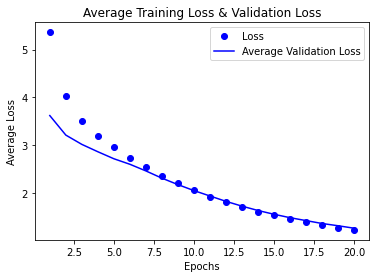

In [49]:
plot_loss(all_loss_7, all_loss_history_7)

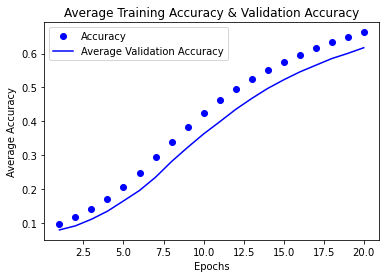

In [50]:
plot_acc(all_acc_7, all_acc_history_7)

In [51]:
print("Average Loss:", np.mean(all_val_loss_7))
print("Average Accuracy:", np.mean(all_val_acc_7))

Average Loss: 1.308309330046177
Average Accuracy: 0.6001058258116245


From the plotted graphs, we can see that adding dropout rates of 0.01 caused the model to overfit. 
To reduce the overfitting, we can increase the L1/L2 regularizer values.

#### Build the Model with L1/L2 Regularizers = 0.07

In [53]:
from keras.layers import BatchNormalization
from keras import regularizers
from keras.regularizers import l1_l2

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_8 = []
all_val_loss_8 = []

all_acc_8 = []
all_loss_8 = []
all_acc_history_8 = []
all_loss_history_8 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_6 = Sequential()

    # Defining model: add layers 
    gru_model_6.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    gru_model_6.add(BatchNormalization()) # BatchNormalization layer 
    gru_model_6.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.07, l2=0.07)))
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.07, l2=0.07))) 
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    gru_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_6.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_8 = gru_model_6.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_6.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_8.append(val_acc)
            all_val_loss_8.append(val_loss)

            acc = results_8.history['accuracy']
            all_acc_8.append(acc)
            acc_history = results_8.history['val_accuracy']
            all_acc_history_8.append(acc_history)

            loss = results_8.history['loss']
            all_loss_8.append(loss)
            loss_history = results_8.history['val_loss']
            all_loss_history_8.append(loss_history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_8 (Batc  (None, 40, 50)           200       
 hNormalization)                                                 
                                                                 
 gru_20 (GRU)                (None, 40, 128)           69120     
                                                                 
 batch_normalization_9 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 gru_21 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_10 (Bat  (None, 64)             

147/147 - 16s - loss: 1.4004 - accuracy: 0.5249 - val_loss: 1.3869 - val_accuracy: 0.5242 - 16s/epoch - 110ms/step
processing fold 0
Epoch 1/5
147/147 - 23s - loss: 1.4827 - accuracy: 0.5033 - val_loss: 1.3552 - val_accuracy: 0.5578 - 23s/epoch - 154ms/step
Epoch 2/5
147/147 - 16s - loss: 1.3920 - accuracy: 0.5145 - val_loss: 1.3026 - val_accuracy: 0.5465 - 16s/epoch - 111ms/step
Epoch 3/5
147/147 - 16s - loss: 1.3536 - accuracy: 0.5310 - val_loss: 1.2951 - val_accuracy: 0.5691 - 16s/epoch - 109ms/step
Epoch 4/5
147/147 - 16s - loss: 1.3481 - accuracy: 0.5492 - val_loss: 1.5159 - val_accuracy: 0.4429 - 16s/epoch - 111ms/step
Epoch 5/5
147/147 - 16s - loss: 1.3867 - accuracy: 0.5336 - val_loss: 1.3762 - val_accuracy: 0.5520 - 16s/epoch - 109ms/step
processing fold 1
Epoch 1/5
147/147 - 21s - loss: 1.4223 - accuracy: 0.5240 - val_loss: 1.3744 - val_accuracy: 0.5007 - 21s/epoch - 143ms/step
Epoch 2/5
147/147 - 16s - loss: 1.3276 - accuracy: 0.5412 - val_loss: 1.3975 - val_accuracy: 0.4658

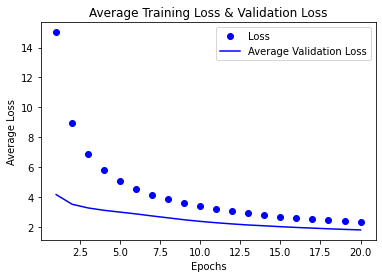

In [54]:
plot_loss(all_loss_8, all_loss_history_8)

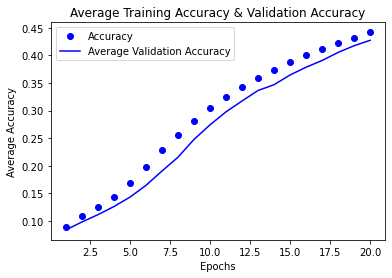

In [55]:
plot_acc(all_acc_8, all_acc_history_8)

In [56]:
print("Average Loss:", np.mean(all_val_loss_8))
print("Average Accuracy:", np.mean(all_val_acc_8))

Average Loss: 1.8320019900798798
Average Accuracy: 0.3983001098036766


#### Build the Model with L1/L2 Regularizers = 0.02

In [59]:
# l1/l2=0.02

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_9 = []
all_val_loss_9 = []

all_acc_9 = []
all_loss_9 = []
all_acc_history_9 = []
all_loss_history_9 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_7 = Sequential()

    # Defining model: add layers 
    gru_model_7.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    gru_model_7.add(BatchNormalization()) # BatchNormalization layer 
    gru_model_7.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    gru_model_7.add(BatchNormalization())
    gru_model_7.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02)))
    gru_model_7.add(BatchNormalization())
    gru_model_7.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02))) 
    gru_model_7.add(BatchNormalization())
    gru_model_7.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    gru_model_7.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_7.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_7.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_9 = gru_model_7.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_6.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_9.append(val_acc)
            all_val_loss_9.append(val_loss)

            acc = results_9.history['accuracy']
            all_acc_9.append(acc)
            acc_history = results_9.history['val_accuracy']
            all_acc_history_9.append(acc_history)

            loss = results_9.history['loss']
            all_loss_9.append(loss)
            loss_history = results_9.history['val_loss']
            all_loss_history_9.append(loss_history)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_16 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_24 (GRU)                (None, 40, 128)           69120     
                                                                 
 batch_normalization_17 (Bat  (None, 40, 128)          512       
 chNormalization)                                                
                                                                 
 gru_25 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_18 (Bat  (None, 64)             

147/147 - 16s - loss: 0.6925 - accuracy: 0.8164 - val_loss: 0.9086 - val_accuracy: 0.7143 - 16s/epoch - 112ms/step
processing fold 0
Epoch 1/5
147/147 - 22s - loss: 0.7733 - accuracy: 0.7839 - val_loss: 0.7273 - val_accuracy: 0.8065 - 22s/epoch - 151ms/step
Epoch 2/5
147/147 - 17s - loss: 0.6432 - accuracy: 0.8271 - val_loss: 0.7261 - val_accuracy: 0.7982 - 17s/epoch - 115ms/step
Epoch 3/5
147/147 - 17s - loss: 0.5940 - accuracy: 0.8486 - val_loss: 0.7680 - val_accuracy: 0.7909 - 17s/epoch - 113ms/step
Epoch 4/5
147/147 - 17s - loss: 0.5694 - accuracy: 0.8557 - val_loss: 1.0428 - val_accuracy: 0.6758 - 17s/epoch - 117ms/step
Epoch 5/5
147/147 - 21s - loss: 0.5609 - accuracy: 0.8578 - val_loss: 0.9349 - val_accuracy: 0.7246 - 21s/epoch - 144ms/step
processing fold 1
Epoch 1/5
147/147 - 22s - loss: 0.7040 - accuracy: 0.8079 - val_loss: 0.5658 - val_accuracy: 0.8593 - 22s/epoch - 148ms/step
Epoch 2/5
147/147 - 17s - loss: 0.5816 - accuracy: 0.8519 - val_loss: 0.5129 - val_accuracy: 0.8776

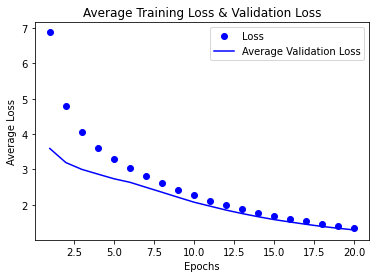

In [60]:
plot_loss(all_loss_9, all_loss_history_9)

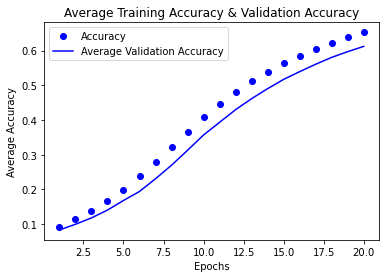

In [63]:
plot_acc(all_acc_9, all_acc_history_9)

In [62]:
print("Average Loss:", np.mean(all_val_loss_9))
print("Average Accuracy:", np.mean(all_val_acc_9))

Average Loss: 1.2882713973522186
Average Accuracy: 0.5535043358802796


#### Build the Model with L1/L2 Regularizers = 0.008

In [64]:
from keras.layers import BatchNormalization
from keras import regularizers
from keras.regularizers import l1_l2

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_8 = []
all_val_loss_8 = []

all_acc_8 = []
all_loss_8 = []
all_acc_history_8 = []
all_loss_history_8 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    gru_model_6 = Sequential()

    # Defining model: add layers 
    gru_model_6.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    gru_model_6.add(BatchNormalization()) # BatchNormalization layer 
    gru_model_6.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.008, l2=0.008)))
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.008, l2=0.008))) 
    gru_model_6.add(BatchNormalization())
    gru_model_6.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    gru_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(gru_model_6.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            gru_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_8 = gru_model_6.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = gru_model_6.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_8.append(val_acc)
            all_val_loss_8.append(val_loss)

            acc = results_8.history['accuracy']
            all_acc_8.append(acc)
            acc_history = results_8.history['val_accuracy']
            all_acc_history_8.append(acc_history)

            loss = results_8.history['loss']
            all_loss_8.append(loss)
            loss_history = results_8.history['val_loss']
            all_loss_history_8.append(loss_history)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_20 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_26 (GRU)                (None, 40, 128)           69120     
                                                                 
 batch_normalization_21 (Bat  (None, 40, 128)          512       
 chNormalization)                                                
                                                                 
 gru_27 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_22 (Bat  (None, 64)             

147/147 - 19s - loss: 0.4973 - accuracy: 0.8783 - val_loss: 1.0235 - val_accuracy: 0.6932 - 19s/epoch - 131ms/step
processing fold 0
Epoch 1/5
147/147 - 24s - loss: 0.5750 - accuracy: 0.8481 - val_loss: 0.5643 - val_accuracy: 0.8444 - 24s/epoch - 162ms/step
Epoch 2/5
147/147 - 19s - loss: 0.4765 - accuracy: 0.8820 - val_loss: 0.6582 - val_accuracy: 0.8154 - 19s/epoch - 129ms/step
Epoch 3/5
147/147 - 19s - loss: 0.4322 - accuracy: 0.8976 - val_loss: 0.5874 - val_accuracy: 0.8353 - 19s/epoch - 129ms/step
Epoch 4/5
147/147 - 19s - loss: 0.4397 - accuracy: 0.8940 - val_loss: 0.7636 - val_accuracy: 0.7813 - 19s/epoch - 128ms/step
Epoch 5/5
147/147 - 19s - loss: 0.4178 - accuracy: 0.9022 - val_loss: 0.8432 - val_accuracy: 0.7645 - 19s/epoch - 130ms/step
processing fold 1
Epoch 1/5
147/147 - 25s - loss: 0.5544 - accuracy: 0.8568 - val_loss: 0.4560 - val_accuracy: 0.8862 - 25s/epoch - 170ms/step
Epoch 2/5
147/147 - 19s - loss: 0.4389 - accuracy: 0.8930 - val_loss: 0.4116 - val_accuracy: 0.8998

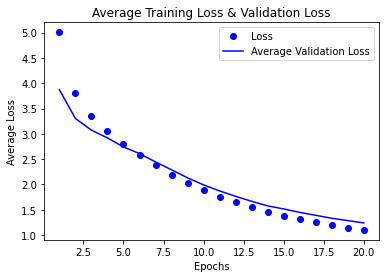

In [65]:
plot_loss(all_loss_8, all_loss_history_8)

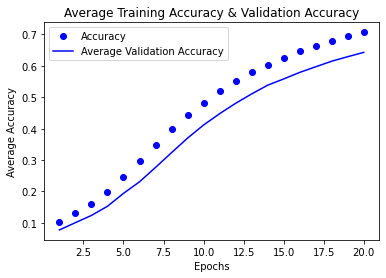

In [66]:
plot_acc(all_acc_8, all_acc_history_8)

In [67]:
print("Average Loss:", np.mean(all_val_loss_8))
print("Average Accuracy:", np.mean(all_val_acc_8))

Average Loss: 1.280747728049755
Average Accuracy: 0.6225636843591928


The average accuracy for L1/L2=0.1 and L1/L2=0.001 are both 0.062. The average loss of the former slightly lower at 2.78 than the latter which was 3.54.

Despite decreasing our L1/L2 regularizers by a 100 times, both our LSTM models with L1/L2 regularizers did not yield good results with severe underfitting. This is most likely due to the fact that our model is trained with a small epoch number. Adding regularizers, that help prevent overfitting, worsened the already slightly underfitting model. 

Hence, we will not be adding L1/L2 regularizers.

The average accuracy and average loss after batch normalisation is 0.744 and 0.790 respectively. 

From the plotted graphs, we have achieved a model with a good fit where the training and validation curves are close to one another without overfitting. 

# Final GRU Model

Now that we have explored 3 different regularization methods - Dropout, L1/L2 Regularizers and Batch Normalisation and also determined the most optimal hyperparameter settings, we will develop our final model. 

The final model will first be trained with a partial training set before being trained on the complete set.

#### Building the final GRU Model

In [72]:
from tensorflow.keras.layers import Dropout, BatchNormalization

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_10 = []
all_val_loss_10 = []

all_acc_10 = []
all_loss_10 = []
all_acc_history_10 = []
all_loss_history_10 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    final_gru_model = Sequential()

    # Defining model: add layers 
    final_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    final_gru_model.add(Dropout(0.07))
    final_gru_model.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.008, l2=0.008))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dropout(0.07))
    final_gru_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.008, l2=0.008))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(final_gru_model.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_10 = final_gru_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = final_gru_model.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_10.append(val_acc)
            all_val_loss_10.append(val_loss)

            acc = results_10.history['accuracy']
            all_acc_10.append(acc)
            acc_history = results_10.history['val_accuracy']
            all_acc_history_10.append(acc_history)

            loss = results_10.history['loss']
            all_loss_10.append(loss)
            loss_history = results_10.history['val_loss']
            all_loss_history_10.append(loss_history)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_26 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_30 (GRU)                (None, 40, 128)           69120     
                                                                 
 dropout_14 (Dropout)        (None, 40, 128)           0         
                                                                 
 gru_31 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_27 (Bat  (None, 64)               256       
 chNormalization)                                    

Epoch 5/5
147/147 - 24s - loss: 0.8818 - accuracy: 0.7464 - val_loss: 1.1623 - val_accuracy: 0.6500 - 24s/epoch - 164ms/step
processing fold 0
Epoch 1/5
147/147 - 33s - loss: 0.9552 - accuracy: 0.7254 - val_loss: 1.2950 - val_accuracy: 0.6189 - 33s/epoch - 228ms/step
Epoch 2/5
147/147 - 18s - loss: 0.8502 - accuracy: 0.7582 - val_loss: 0.8931 - val_accuracy: 0.7515 - 18s/epoch - 124ms/step
Epoch 3/5
147/147 - 20s - loss: 0.8087 - accuracy: 0.7789 - val_loss: 2.2224 - val_accuracy: 0.4024 - 20s/epoch - 134ms/step
Epoch 4/5
147/147 - 22s - loss: 0.7771 - accuracy: 0.7869 - val_loss: 1.6729 - val_accuracy: 0.5051 - 22s/epoch - 148ms/step
Epoch 5/5
147/147 - 22s - loss: 0.7477 - accuracy: 0.7998 - val_loss: 1.9170 - val_accuracy: 0.4706 - 22s/epoch - 153ms/step
processing fold 1
Epoch 1/5
147/147 - 34s - loss: 0.8806 - accuracy: 0.7594 - val_loss: 1.7219 - val_accuracy: 0.4726 - 34s/epoch - 228ms/step
Epoch 2/5
147/147 - 22s - loss: 0.7718 - accuracy: 0.7869 - val_loss: 0.7376 - val_accura

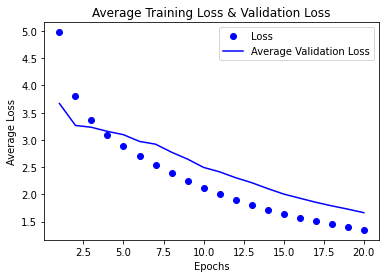

In [73]:
plot_loss(all_loss_10, all_loss_history_10)

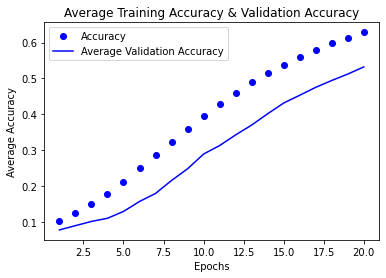

In [74]:
plot_acc(all_acc_10, all_acc_history_10)

In [75]:
print("Average Loss:", np.mean(all_val_loss_10))
print("Average Accuracy:", np.mean(all_val_acc_10))

Average Loss: 1.8347479939460754
Average Accuracy: 0.5068152971565724


<b> dropout = 0.05 l1/l2 = 0.005</b>

In [77]:
from tensorflow.keras.layers import Dropout, BatchNormalization

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_10 = []
all_val_loss_10 = []

all_acc_10 = []
all_loss_10 = []
all_acc_history_10 = []
all_loss_history_10 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    final_gru_model = Sequential()

    # Defining model: add layers 
    final_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    final_gru_model.add(Dropout(0.05))
    final_gru_model.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dropout(0.05))
    final_gru_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(final_gru_model.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_10 = final_gru_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = final_gru_model.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_10.append(val_acc)
            all_val_loss_10.append(val_loss)

            acc = results_10.history['accuracy']
            all_acc_10.append(acc)
            acc_history = results_10.history['val_accuracy']
            all_acc_history_10.append(acc_history)

            loss = results_10.history['loss']
            all_loss_10.append(loss)
            loss_history = results_10.history['val_loss']
            all_loss_history_10.append(loss_history)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_32 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_34 (GRU)                (None, 40, 128)           69120     
                                                                 
 dropout_18 (Dropout)        (None, 40, 128)           0         
                                                                 
 gru_35 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_33 (Bat  (None, 64)               256       
 chNormalization)                                    

Epoch 5/5
147/147 - 19s - loss: 0.8355 - accuracy: 0.7634 - val_loss: 1.7724 - val_accuracy: 0.5010 - 19s/epoch - 127ms/step
processing fold 0
Epoch 1/5
147/147 - 27s - loss: 0.8779 - accuracy: 0.7507 - val_loss: 0.7430 - val_accuracy: 0.8099 - 27s/epoch - 181ms/step
Epoch 2/5
147/147 - 20s - loss: 0.8091 - accuracy: 0.7733 - val_loss: 0.8277 - val_accuracy: 0.7720 - 20s/epoch - 139ms/step
Epoch 3/5
147/147 - 24s - loss: 0.7744 - accuracy: 0.7917 - val_loss: 0.8747 - val_accuracy: 0.7547 - 24s/epoch - 160ms/step
Epoch 4/5
147/147 - 26s - loss: 0.7520 - accuracy: 0.7995 - val_loss: 0.8590 - val_accuracy: 0.7547 - 26s/epoch - 179ms/step
Epoch 5/5
147/147 - 24s - loss: 0.7164 - accuracy: 0.8093 - val_loss: 1.0188 - val_accuracy: 0.6984 - 24s/epoch - 164ms/step
processing fold 1
Epoch 1/5
147/147 - 52s - loss: 0.8143 - accuracy: 0.7769 - val_loss: 0.8134 - val_accuracy: 0.7715 - 52s/epoch - 354ms/step
Epoch 2/5
147/147 - 35s - loss: 0.7546 - accuracy: 0.7939 - val_loss: 0.7233 - val_accura

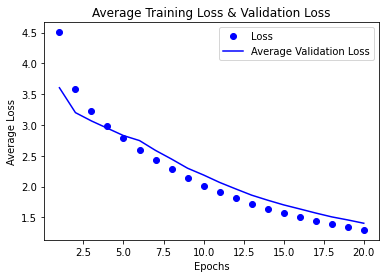

In [78]:
plot_loss(all_loss_10, all_loss_history_10)

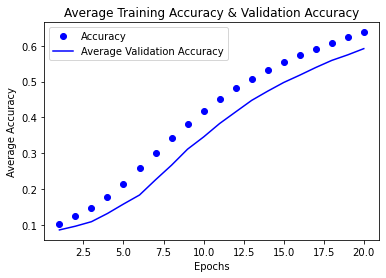

In [79]:
plot_acc(all_acc_10, all_acc_history_10)

In [80]:
print("Average Loss:", np.mean(all_val_loss_10))
print("Average Accuracy:", np.mean(all_val_acc_10))

Average Loss: 1.4886052906513214
Average Accuracy: 0.5605641074478627


<b> dropout = 0.03 l1/l2 = 0.001 </b>

In [82]:
from tensorflow.keras.layers import Dropout, BatchNormalization

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_10 = []
all_val_loss_10 = []

all_acc_10 = []
all_loss_10 = []
all_acc_history_10 = []
all_loss_history_10 = []

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    final_gru_model = Sequential()

    # Defining model: add layers 
    final_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    final_gru_model.add(Dropout(0.03))
    final_gru_model.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dropout(0.03))
    final_gru_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(final_gru_model.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            results_10 = final_gru_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))

            # Evaluate the model on the validation data: loss and accuracy 
            val_loss, val_acc = final_gru_model.evaluate(val_data, val_targets, verbose=0)
            all_val_acc_10.append(val_acc)
            all_val_loss_10.append(val_loss)

            acc = results_10.history['accuracy']
            all_acc_10.append(acc)
            acc_history = results_10.history['val_accuracy']
            all_acc_history_10.append(acc_history)

            loss = results_10.history['loss']
            all_loss_10.append(loss)
            loss_history = results_10.history['val_loss']
            all_loss_history_10.append(loss_history)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_38 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_38 (GRU)                (None, 40, 128)           69120     
                                                                 
 dropout_22 (Dropout)        (None, 40, 128)           0         
                                                                 
 gru_39 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_39 (Bat  (None, 64)               256       
 chNormalization)                                    

Epoch 5/5
147/147 - 16s - loss: 0.4393 - accuracy: 0.9358 - val_loss: 0.5443 - val_accuracy: 0.8923 - 16s/epoch - 110ms/step
processing fold 0
Epoch 1/5
147/147 - 88s - loss: 0.5267 - accuracy: 0.9031 - val_loss: 0.4379 - val_accuracy: 0.9390 - 88s/epoch - 597ms/step
Epoch 2/5
147/147 - 18s - loss: 0.4334 - accuracy: 0.9382 - val_loss: 0.4416 - val_accuracy: 0.9358 - 18s/epoch - 122ms/step
Epoch 3/5
147/147 - 16s - loss: 0.4220 - accuracy: 0.9394 - val_loss: 0.5196 - val_accuracy: 0.9094 - 16s/epoch - 109ms/step
Epoch 4/5
147/147 - 18s - loss: 0.4271 - accuracy: 0.9382 - val_loss: 0.6026 - val_accuracy: 0.8760 - 18s/epoch - 125ms/step
Epoch 5/5
147/147 - 17s - loss: 0.4296 - accuracy: 0.9364 - val_loss: 0.6451 - val_accuracy: 0.8645 - 17s/epoch - 114ms/step
processing fold 1
Epoch 1/5
147/147 - 25s - loss: 0.5533 - accuracy: 0.8994 - val_loss: 0.3835 - val_accuracy: 0.9591 - 25s/epoch - 171ms/step
Epoch 2/5
147/147 - 17s - loss: 0.4213 - accuracy: 0.9382 - val_loss: 0.3757 - val_accura

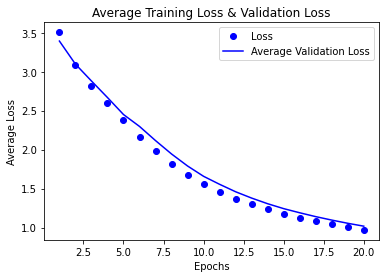

In [83]:
plot_loss(all_loss_10, all_loss_history_10)

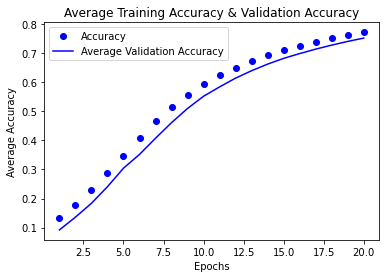

In [84]:
plot_acc(all_acc_10, all_acc_history_10)

In [86]:
print("Average Loss:", np.mean(all_val_loss_10))
print("Average Accuracy:", np.mean(all_val_acc_10))
print("Average Validation Acc:", np.mean(all_acc_10))

Average Loss: 1.0942971110343933
Average Accuracy: 0.7207160253077746
Average Validation Acc: 0.7708162669837475


#### Training the final GRU model with the COMPLETE training set 

In [137]:
from tensorflow.keras.layers import Dropout, BatchNormalization

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

N_iterations=4
N_folds=5

with tf.device("/gpu:0"):
    # Initialising the model 
    final_gru_model = Sequential()

    # Defining model: add layers 
    final_gru_model.add(Embedding(
        max_words,
        EMBEDDING_VECTOR_LENGTH,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True,
    )) #glove embedding

    final_gru_model.add(BatchNormalization())
    final_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
    final_gru_model.add(Dropout(0.03))
    final_gru_model.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dropout(0.03))
    final_gru_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
    final_gru_model.add(BatchNormalization())
    final_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

    # Compile model
    final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(final_gru_model.summary())

    for i in range(N_iterations):
        skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

        for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
            print('processing fold', j)

            partial_train_data = X_train_resampled[train_index]
            val_data = X_train_resampled[val_index]

            partial_train_targets = y_train_resampled[train_index]
            val_targets = y_train_resampled[val_index]

            # One-hot encode the target labels
            partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
            val_targets = to_categorical(val_targets, num_classes=16)

            # Train the model 
            final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
            final_gru_model.fit(np.concatenate([partial_train_data, val_data]), np.concatenate([partial_train_targets, val_targets]), epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))        

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_44 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 gru_42 (GRU)                (None, 40, 128)           69120     
                                                                 
 dropout_26 (Dropout)        (None, 40, 128)           0         
                                                                 
 gru_43 (GRU)                (None, 64)                37248     
                                                                 
 batch_normalization_45 (Bat  (None, 64)               256       
 chNormalization)                                    

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

N_iterations=4
N_folds=5

# Initialising the model 
final_gru_model = Sequential()

# Defining model: add layers 
final_gru_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding

final_gru_model.add(BatchNormalization())
final_gru_model.add(GRU(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #GRU layer
final_gru_model.add(Dropout(0.03))
final_gru_model.add(GRU(64, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
final_gru_model.add(BatchNormalization())
final_gru_model.add(Dropout(0.03))
final_gru_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))) # Additional dense layer
final_gru_model.add(BatchNormalization())
final_gru_model.add(Dense(16, activation='softmax')) #dense layer - the last one

# Compile model
final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(final_gru_model.summary())

for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)

    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)

        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]

        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]

        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)

        # Train the model 
        final_gru_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        final_gru_model.fit(np.concatenate([partial_train_data, val_data]), np.concatenate([partial_train_targets, val_targets]), epochs=num_epochs, batch_size=128, verbose=2, validation_data = (val_data, val_targets))        

In [98]:
test_loss, test_acc = final_gru_model.evaluate(X_test_gru_pad,
                                          y_test_gru_onehot)

55/55 [==============================] - 1s 22ms/step - loss: 11.6311 - accuracy: 0.1401


From the results above, we can see that the accuracy of the model is not very high. 14.01% 

### Save Final GRU Model

In [140]:
# save model to be used for test-gru 
final_gru_model.save('final_gru_model.h5')